In [ ]:
!pip3 install muq


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import librosa
import torch
import pandas as pd
from tqdm import tqdm
from muq import MuQMuLan
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [ ]:
# --------------------------------------------------
# 1. Load model
# --------------------------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mulan = MuQMuLan.from_pretrained("OpenMuQ/MuQ-MuLan-large").to(device).eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.65G [00:00<?, ?B/s]

In [ ]:
# --------------------------------------------------
# 2. Paths and data
# --------------------------------------------------
csv_path_chinese = "/content/drive/MyDrive/timbre_semantics/Chinese.csv"
audio_folder_chinese = "/content/drive/MyDrive/timbre_semantics/audio/Chinese"

csv_path_western = "/content/drive/MyDrive/timbre_semantics/Western.csv"
audio_folder_western = "/content/drive/MyDrive/timbre_semantics/audio/Western"

output_dir = "/content/drive/MyDrive/timbre_study_exp1/results"
os.makedirs(output_dir, exist_ok=True)

df_chinese = pd.read_csv(csv_path_chinese)
df_western = pd.read_csv(csv_path_western)
descriptors = df_western.columns[2:].tolist()

In [ ]:

# -------------------------
# 2) Helpers
# -------------------------
def get_audio_embeddings(file_paths):
    """Return torch.Tensor of shape (N, D) on device."""
    embs = []
    for p in tqdm(file_paths, desc="Audio -> MuQ-MuLan"):
        wav, _ = librosa.load(p, sr=24000)
        wav_tensor = torch.tensor(wav, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = mulan(wavs=wav_tensor)          # (1, D)
        embs.append(emb)
    return torch.cat(embs, dim=0)                  # (N, D)

def get_text_embeddings(text_list):
    """Return torch.Tensor of shape (T, D) on device."""
    with torch.no_grad():
        emb = mulan(texts=text_list).to(device)    # (T, D)
    return emb

def muq_similarity_matrix(audio_embs, text_embs):
    """Use mulan.calc_similarity; returns numpy (N, T)."""
    with torch.no_grad():
        sim = mulan.calc_similarity(audio_embs, text_embs)  # (N, T) torch
    return sim.detach().cpu().numpy()

In [ ]:
# -------------------------
# 3) Build paths & embeddings
# -------------------------
chinese_paths = [os.path.join(audio_folder_chinese, f"{int(row['instrument_id'])}.wav") for _, row in df_chinese.iterrows()]
western_paths = [os.path.join(audio_folder_western, f"{int(row['instrument_id'])}.wav") for _, row in df_western.iterrows()]

text_embs = get_text_embeddings(descriptors)                   # (T, D)
audio_embs_ch = get_audio_embeddings(chinese_paths)            # (Nc, D)
audio_embs_we = get_audio_embeddings(western_paths)            # (Nw, D)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Audio -> MuQ-MuLan: 100%|██████████| 24/24 [06:31<00:00, 16.31s/it]


In [ ]:
# -------------------------
# 4) Similarity matrices
# -------------------------
sim_ch = muq_similarity_matrix(audio_embs_ch, text_embs)       # (Nc, T)
sim_we = muq_similarity_matrix(audio_embs_we, text_embs)       # (Nw, T)

similarity_df_ch = pd.DataFrame(sim_ch, columns=descriptors, index=df_chinese['instrument_name'])
similarity_df_we = pd.DataFrame(sim_we, columns=descriptors, index=df_western['instrument_name'])


In [ ]:
# -------------------------
# 5) Descriptor-level correlations (across instruments)
# -------------------------
combined_ratings = pd.concat([df_chinese[descriptors], df_western[descriptors]], ignore_index=True)
combined_similarities = pd.concat([similarity_df_ch[descriptors], similarity_df_we[descriptors]], ignore_index=True)

desc_rows = []
for desc in descriptors:
    human = combined_ratings[desc].values
    model = combined_similarities[desc].values
    pr, _ = pearsonr(human, model)
    sr, _ = spearmanr(human, model)
    desc_rows.append({"descriptor": desc, "pearson": pr, "spearman": sr})

desc_corr_df = pd.DataFrame(desc_rows)
desc_corr_df.to_csv(os.path.join(output_dir, "muq_descriptor_correlation_combined.csv"), index=False)


In [ ]:
# -------------------------
# 6) Instrument-level (semantic profile) correlations
# -------------------------

df_chinese[descriptors] = df_chinese[descriptors].apply(pd.to_numeric, errors='coerce')
df_western[descriptors] = df_western[descriptors].apply(pd.to_numeric, errors='coerce')

similarity_df_ch[descriptors] = similarity_df_ch[descriptors].apply(pd.to_numeric, errors='coerce')
similarity_df_we[descriptors] = similarity_df_we[descriptors].apply(pd.to_numeric, errors='coerce')

def profile_corr(human_df, model_df, name_col):
    rows = []
    for _, row in human_df.iterrows():
        name = row[name_col]

        human_vec = pd.to_numeric(row[descriptors], errors='coerce').to_numpy(dtype=float)
        model_series = model_df.loc[name, descriptors]
        model_vec = pd.to_numeric(model_series, errors='coerce').to_numpy(dtype=float)

        # Pairwise valid mask
        mask = np.isfinite(human_vec) & np.isfinite(model_vec)
        if mask.sum() >= 2:
            pr, _ = pearsonr(human_vec[mask], model_vec[mask])
            sr, _ = spearmanr(human_vec[mask], model_vec[mask])
        else:
            pr, sr = np.nan, np.nan

        rows.append({"instrument": name, "pearson": pr, "spearman": sr})
    return pd.DataFrame(rows)


In [ ]:
prof_corr_ch = profile_corr(df_chinese, similarity_df_ch, "instrument_name")
prof_corr_we = profile_corr(df_western, similarity_df_we, "instrument_name")
prof_corr_all = pd.concat([prof_corr_ch, prof_corr_we], ignore_index=True)

# Exports
prof_corr_ch.to_csv(os.path.join(output_dir, "muq_profile_correlation_chinese.csv"), index=False)
prof_corr_we.to_csv(os.path.join(output_dir, "muq_profile_correlation_western.csv"), index=False)
prof_corr_all.to_csv(os.path.join(output_dir, "muq_profile_correlation_combined.csv"), index=False)


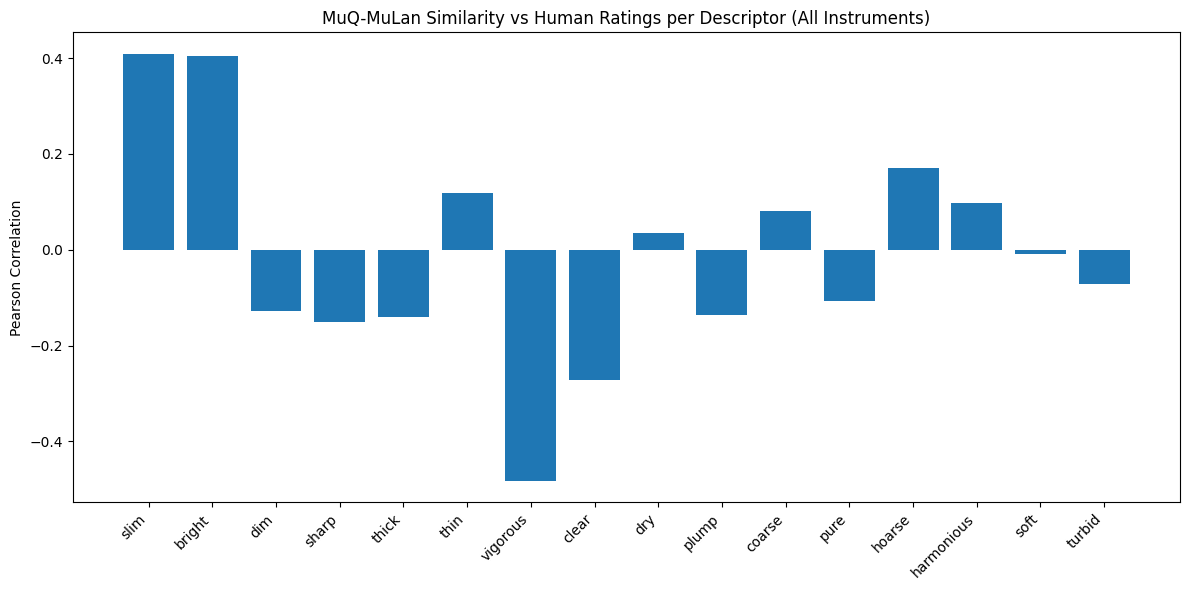

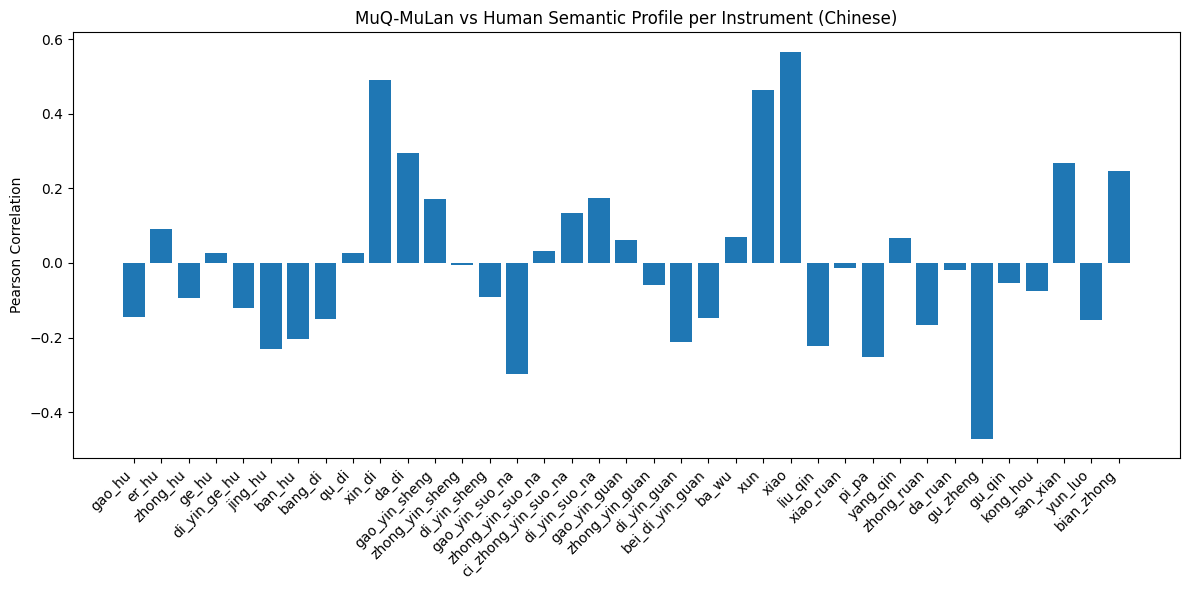

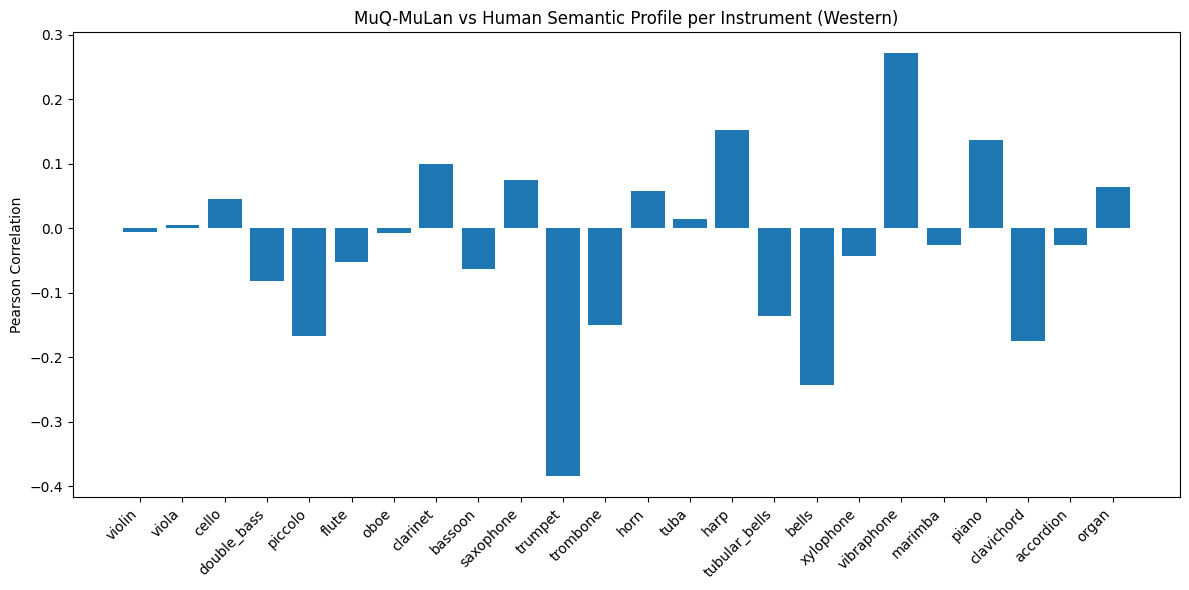

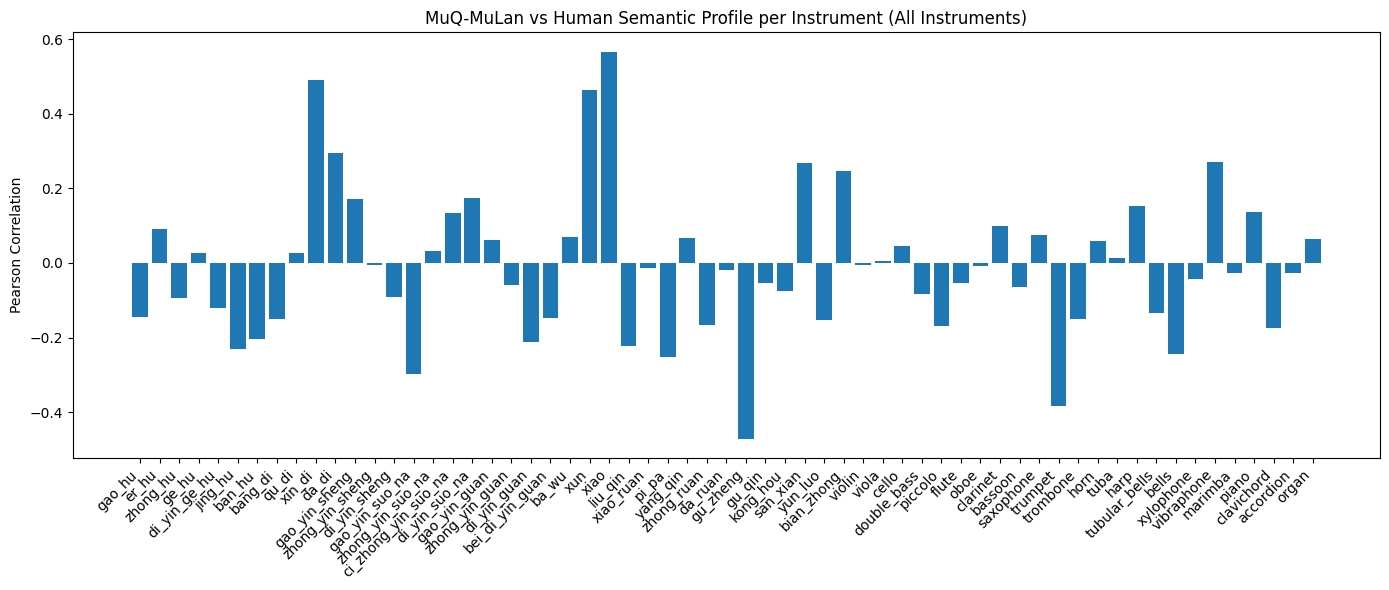

In [ ]:
# -------------------------
# 7) Plots 
# -------------------------

# Descriptor-level (all instruments)
plt.figure(figsize=(12, 6))
plt.bar(desc_corr_df['descriptor'], desc_corr_df['pearson'])
plt.ylabel('Pearson Correlation')
plt.title('MuQ-MuLan Similarity vs Human Ratings per Descriptor (All Instruments)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "muq_descriptor_correlation_combined.png"))
plt.show()

# Instrument-level (Chinese only)
plt.figure(figsize=(12, 6))
plt.bar(prof_corr_ch['instrument'], prof_corr_ch['pearson'])
plt.ylabel('Pearson Correlation')
plt.title('MuQ-MuLan vs Human Semantic Profile per Instrument (Chinese)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "muq_profile_correlation_per_instrument_chinese.png"))
plt.show()

# Instrument-level (Western only)
plt.figure(figsize=(12, 6))
plt.bar(prof_corr_we['instrument'], prof_corr_we['pearson'])
plt.ylabel('Pearson Correlation')
plt.title('MuQ-MuLan vs Human Semantic Profile per Instrument (Western)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "muq_profile_correlation_per_instrument_western.png"))
plt.show()

# Instrument-level (All instruments)
plt.figure(figsize=(14, 6))
plt.bar(prof_corr_all['instrument'], prof_corr_all['pearson'])
plt.ylabel('Pearson Correlation')
plt.title('MuQ-MuLan vs Human Semantic Profile per Instrument (All Instruments)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "muq_profile_correlation_per_instrument_all.png"))
plt.show()